In [1]:
import pandas as pd
import os
from PIL import Image
from tqdm import tqdm
import numpy as np
from numpy import asarray
import tensorflow as tf  
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import cv2
from torchvision.io import read_image
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch
from torch import nn
import torch.optim as optim
%matplotlib inline

# Data Standardization

In [2]:
df = pd.read_csv('Data_labels.csv')

In [3]:
images_ = list(df['Image_name'])

In [4]:
""" Images are Converted in to 32 x 32 and Converting to 3 Channel Image RGB """
if(os.path.isdir('proc_images') == False):
    os.mkdir('proc_images')
    image_not = []
    for i in tqdm(range(len(images_))):
        try:
            image = Image.open("Images/"+images_[i]+'.jpg')
            image = image.resize((32,32),Image.ANTIALIAS)
            image = image.convert('RGB')
            image.save("proc_images/"+images_[i]+".png", format="png")
        except:
            image_not.append(i)
else:
    print("Folder Already Exists")

100%|█████████████████████████████████████████| 516/516 [02:20<00:00,  3.67it/s]


# Image Sampling

In [5]:
""" Loading Image Data """
image_data = []
for i in tqdm(range(len(images_))):
        try:
            image = Image.open("proc_images/"+images_[i]+'.png')
            data = np.asarray(image)
            image_data.append(data)
        except:
            image_not.append(i)
            print("Error Loading "+ i)

100%|███████████████████████████████████████| 516/516 [00:00<00:00, 2663.58it/s]


In [6]:
image_data = np.asarray(image_data)
image_data.shape

(516, 32, 32, 3)

In [7]:
def eudist2d(x):
    '''TO FLATTEN THE IMAGE'''
    b = x.flatten()
    return b

In [8]:
X = []
[X.append(eudist2d(i)) for i in image_data]
X = np.array(X)

### Applying KElbowVisualizer

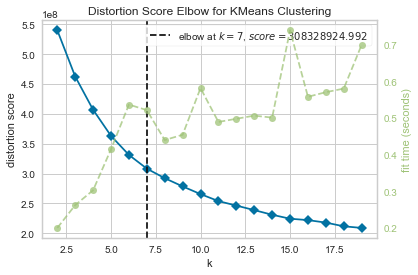

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,20))
visualizer.fit(X)
visualizer.show()

In [10]:
kmeans = KMeans(n_clusters=visualizer.elbow_value_, random_state=0).fit(X)

In [11]:
preds = kmeans.predict(X)

In [12]:
df['kmean_class'] = preds

In [13]:
uniq_class = df['kmean_class'].unique()

In [14]:
sampledf = []
for i in uniq_class:
    temp_df = df[df['kmean_class'] == i]
    msk = np.random.rand(len(temp_df)) < 0.7
    temp_df = temp_df[msk]
    sampledf.append(temp_df)
sampledf = pd.concat(sampledf)

In [15]:
sampledf.to_csv('seg_img.csv',index = False)

# Image Segmentation 

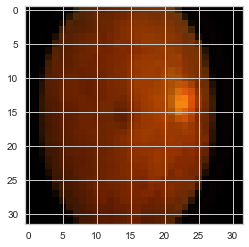

In [16]:
image = cv2.imread('proc_images/IMG_2.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

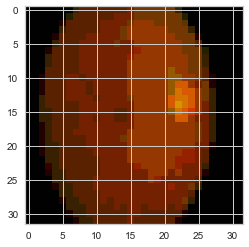

In [17]:
pixel_vals = image.reshape((-1,1))
pixel_vals = np.float32(pixel_vals)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
k = 7
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
segmented_image = segmented_data.reshape((image.shape))
plt.imshow(segmented_image)

100%|█████████████████████████████████████████| 365/365 [00:08<00:00, 45.46it/s]


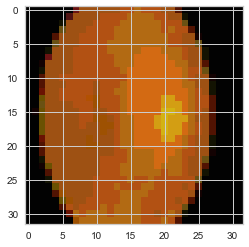

In [23]:
images_ = list(sampledf['Image_name'])
if(os.path.isdir('seg_images') == False):
    os.mkdir('seg_images')
else:
    image_not = []
    for i in tqdm(range(len(images_))):
        image = cv2.imread('proc_images/'+images_[i]+'.png')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        pixel_vals = image.reshape((-1,1))
        pixel_vals = np.float32(pixel_vals)
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
        k = 7
        retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
        centers = np.uint8(centers)
        segmented_data = centers[labels.flatten()]
        segmented_image = segmented_data.reshape((image.shape))
        plt.imshow(segmented_image)
        cv2.imwrite('seg_images/'+images_[i]+'.png', segmented_image)


## Machine Learning 

#### GuassianNB
Naïve Bayes is a probabilistic machine learning algorithm used for many classification functions and is based on the Bayes theorem. Gaussian Naïve Bayes is the extension of naïve Bayes.

In [24]:
from sklearn.naive_bayes import GaussianNB

In [25]:
def Accuracy(d,Y_test):
    temp = 0
    for i in range(len(d)):
        if(d[i]==Y_test[i]):
            temp +=1
    return (temp/len(d))*100

In [26]:
level = list(sampledf['kmean_class'])

In [27]:
""" Image Loading Segmented """
image_data = []
for i in tqdm(range(len(images_))):
    try:
        image = Image.open("seg_images/"+images_[i]+'.png')
        data = np.asarray(image)
        image_data.append(data)
    except:
        print("Error Loading "+ images_[i])
image_data = np.asarray(image_data)

100%|███████████████████████████████████████| 365/365 [00:00<00:00, 3381.98it/s]


In [28]:
X_t,y_t = image_data[0:300],level[0:300]

In [29]:
X_test,y_test = image_data[300:],level[300:]

In [30]:
gnb = GaussianNB()

In [31]:
X = []
[X.append(eudist2d(i)) for i in X_t]
x_test = np.array(X)
gnb.fit(X, y_t)

GaussianNB()

In [32]:
X = []
[X.append(eudist2d(i)) for i in X_test]
x_test = np.array(X)
ypred = gnb.predict(x_test)

In [33]:
print("The Accuracy of Naive Bays Machine Learning Model is :",Accuracy(ypred,y_test))

The Accuracy of Naive Bays Machine Learning Model is : 30.76923076923077


#### KNN 

In [34]:
from sklearn.neighbors import KNeighborsClassifier

In [39]:
neigh = KNeighborsClassifier(n_neighbors=7)

In [40]:
X = []
[X.append(eudist2d(i)) for i in X_t]
x_test = np.array(X)
neigh.fit(X, y_t)

KNeighborsClassifier(n_neighbors=7)

In [41]:
X = []
[X.append(eudist2d(i)) for i in X_test]
x_test = np.array(X)
ypred = neigh.predict(x_test)

In [42]:
print("The Accuracy of KNN Machine Learning Model is :",Accuracy(ypred,y_test))

The Accuracy of KNN Machine Learning Model is : 26.153846153846157


# DataLoader for Neural Network

In [47]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0].replace(' ',"")+'.png')
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 2]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        labelarray = torch.as_tensor(label)
        return image.float(), labelarray

In [48]:
train, validate, test = np.split(sampledf.sample(frac=1, random_state=42), [int(.8*len(sampledf)), int(.9*len(sampledf))])
train.to_csv("train.csv",index=False)
validate.to_csv("validate.csv",index=False)
test.to_csv("test.csv",index=False)

In [49]:
train_data = CustomImageDataset(annotations_file="train.csv",
                   img_dir="./seg_images")
val_data = CustomImageDataset(annotations_file="validate.csv",
                   img_dir="./seg_images")
test_data = CustomImageDataset(annotations_file="test.csv",
                   img_dir="./seg_images")

In [50]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=32,num_workers=0,pin_memory=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=32)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=32)

# Simple Neural Network

In [66]:
class FirstModel(nn.Module): #For images
    def __init__(self):
        super(FirstModel, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 7),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [74]:
model=FirstModel()


In [75]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [76]:
learning_rate = 1e-3
batch_size = 128
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 45
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 6.543232  [    0/  292]
Test Error: 
 Accuracy: 16.2%, Avg loss: 55.362720 

Epoch 2
-------------------------------
loss: 52.977978  [    0/  292]
Test Error: 
 Accuracy: 29.7%, Avg loss: 8.682800 

Epoch 3
-------------------------------
loss: 9.746601  [    0/  292]
Test Error: 
 Accuracy: 21.6%, Avg loss: 4.108769 

Epoch 4
-------------------------------
loss: 2.967309  [    0/  292]
Test Error: 
 Accuracy: 37.8%, Avg loss: 2.218903 

Epoch 5
-------------------------------
loss: 1.719147  [    0/  292]
Test Error: 
 Accuracy: 51.4%, Avg loss: 1.745792 

Epoch 6
-------------------------------
loss: 1.657472  [    0/  292]
Test Error: 
 Accuracy: 54.1%, Avg loss: 1.070620 

Epoch 7
-------------------------------
loss: 1.275015  [    0/  292]
Test Error: 
 Accuracy: 59.5%, Avg loss: 0.999015 

Epoch 8
-------------------------------
loss: 1.009432  [    0/  292]
Test Error: 
 Accuracy: 67.6%, Avg loss: 0.860967 

Epoch 9
--------------

#### THE ACCURACY OF SIMPLE NEURAL NETWORK 75.7% and Loss is 1.48

# CNN Neural Network

In [77]:
train_data = CustomImageDataset(annotations_file="train.csv",
                   img_dir="./seg_images")
val_data = CustomImageDataset(annotations_file="validate.csv",
                   img_dir="./seg_images")
test_data = CustomImageDataset(annotations_file="test.csv",
                   img_dir="./seg_images")

In [78]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=32,num_workers=0,pin_memory=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=32)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=32)

In [83]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 7)  
        self.conv2 = nn.Conv2d(10, 21, 5)
        self.pool = nn.MaxPool2d(2, stride=1) 
        self.pool2 = nn.MaxPool2d(4, stride=2) 
        self.fc1 = nn.Linear(1701, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7) 



    def forward(self, x):
        z = nn.functional.relu(self.conv1(x))  
        z = self.pool(z)                         
        z = nn.functional.relu(self.conv2(z))
        z = self.pool2(z)                         
        
        z = torch.flatten(z, 1)   
        z = nn.functional.relu(self.fc1(z))
        z = nn.functional.relu(self.fc2(z))
        z = self.fc3(z)
        return z


net = Net()

In [84]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [87]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in tqdm(range(10)):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 10 ==10:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 9:.3f}')
            running_loss = 0.0
    for i, data in enumerate(test_dataloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

print('Finished Training')

100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.83it/s]

Finished Training


In [88]:
correct = 0
total = 0
with torch.no_grad():
    for data in val_dataloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')

Accuracy of the network on the 36 test images: 83 %


### THE ACCURACY OF SIMPLE NEURAL NETWORK 83% and Loss is 1.82

# UNSEGMENTED IMAGES

In [89]:
level = list(df['kmean_class'])

In [90]:
""" Image Loading Segmented """
image_data = []
for i in tqdm(range(len(images_))):
    try:
        image = Image.open("proc_images/"+images_[i]+'.png')
        data = np.asarray(image)
        image_data.append(data)
    except:
        print("Error Loading "+ images_[i])
image_data = np.asarray(image_data)

100%|███████████████████████████████████████| 365/365 [00:00<00:00, 2834.76it/s]


In [91]:
X_t,y_t = image_data[0:300],level[0:300]

In [92]:
X_test,y_test = image_data[300:],level[300:]

In [93]:
gnb = GaussianNB()

In [94]:
X = []
[X.append(eudist2d(i)) for i in X_t]
x_test = np.array(X)
gnb.fit(X, y_t)

GaussianNB()

In [95]:
X = []
[X.append(eudist2d(i)) for i in X_test]
x_test = np.array(X)
ypred = gnb.predict(x_test)

In [96]:
print("The Accuracy of Naive Bays Machine Learning Model is :",Accuracy(ypred,y_test))

The Accuracy of Naive Bays Machine Learning Model is : 7.6923076923076925


#### KNN

In [98]:
from sklearn.neighbors import KNeighborsClassifier

In [99]:
neigh = KNeighborsClassifier(n_neighbors=5)

In [100]:
X = []
[X.append(eudist2d(i)) for i in X_t]
x_test = np.array(X)
neigh.fit(X, y_t)

KNeighborsClassifier()

In [101]:
X = []
[X.append(eudist2d(i)) for i in X_test]
x_test = np.array(X)
ypred = neigh.predict(x_test)

In [102]:
print("The Accuracy of KNN Machine Learning Model is :",Accuracy(ypred,y_test))

The Accuracy of KNN Machine Learning Model is : 7.6923076923076925


In [103]:
train_data = CustomImageDataset(annotations_file="train.csv",
                   img_dir="./proc_images")
val_data = CustomImageDataset(annotations_file="validate.csv",
                   img_dir="./proc_images")
test_data = CustomImageDataset(annotations_file="test.csv",
                   img_dir="./proc_images")

In [104]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=32,num_workers=0,pin_memory=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=32)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=32)

# Simple ANN Non Segmented

In [133]:
class FirstModel(nn.Module): #For images
    def __init__(self):
        super(FirstModel, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 7),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [134]:
model=FirstModel()

In [135]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [136]:
learning_rate = 1e-3
batch_size = 128
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 10.579122  [    0/  292]
Test Error: 
 Accuracy: 18.9%, Avg loss: 27.310266 

Epoch 2
-------------------------------
loss: 28.949289  [    0/  292]
Test Error: 
 Accuracy: 24.3%, Avg loss: 12.679225 

Epoch 3
-------------------------------
loss: 12.559673  [    0/  292]
Test Error: 
 Accuracy: 51.4%, Avg loss: 3.282126 

Epoch 4
-------------------------------
loss: 3.384794  [    0/  292]
Test Error: 
 Accuracy: 45.9%, Avg loss: 2.615881 

Epoch 5
-------------------------------
loss: 2.523471  [    0/  292]
Test Error: 
 Accuracy: 45.9%, Avg loss: 1.490701 

Epoch 6
-------------------------------
loss: 1.279835  [    0/  292]
Test Error: 
 Accuracy: 48.6%, Avg loss: 1.321491 

Epoch 7
-------------------------------
loss: 1.281961  [    0/  292]
Test Error: 
 Accuracy: 54.1%, Avg loss: 1.194026 

Epoch 8
-------------------------------
loss: 1.109163  [    0/  292]
Test Error: 
 Accuracy: 51.4%, Avg loss: 1.049103 

Epoch 9
-----------

#### THE ACCURACY OF SIMPLE NEURAL NETWORK 75.7% and Loss is 1.48

# CNN NON SEGMENTED

In [137]:
train_data = CustomImageDataset(annotations_file="train.csv",
                   img_dir="./proc_images")
val_data = CustomImageDataset(annotations_file="validate.csv",
                   img_dir="./proc_images")
test_data = CustomImageDataset(annotations_file="test.csv",
                   img_dir="./proc_images")

In [138]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=32,num_workers=0,pin_memory=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=32)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=32)

In [142]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 7)  
        self.conv2 = nn.Conv2d(10, 21, 5)
        self.pool = nn.MaxPool2d(2, stride=1) 
        self.pool2 = nn.MaxPool2d(4, stride=2) 
        self.fc1 = nn.Linear(1701, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7) 



    def forward(self, x):
        z = nn.functional.relu(self.conv1(x))  
        z = self.pool(z)                         
        z = nn.functional.relu(self.conv2(z))
        z = self.pool2(z)                         
        
        z = torch.flatten(z, 1)   
        z = nn.functional.relu(self.fc1(z))
        z = nn.functional.relu(self.fc2(z))
        z = self.fc3(z)
        return z


net = Net()

In [143]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [144]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in tqdm(range(10)):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 10 ==10:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 9:.3f}')
            running_loss = 0.0
    for i, data in enumerate(test_dataloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

print('Finished Training')

100%|███████████████████████████████████████████| 10/10 [00:06<00:00,  1.50it/s]

Finished Training


In [145]:
correct = 0
total = 0
with torch.no_grad():
    for data in val_dataloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')

Accuracy of the network on the 36 test images: 86 %


# Advance Segmentation

(-0.5, 31.5, 31.5, -0.5)

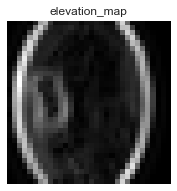

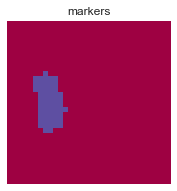

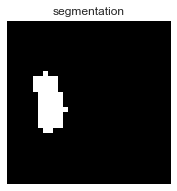

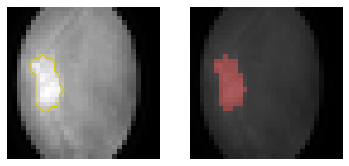

In [146]:
from skimage.filters import sobel
from skimage.segmentation import watershed
from scipy import ndimage as ndi
from skimage.color import label2rgb

image = cv2.imread('proc_images/IMG_3.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
elevation_map = sobel(image)
fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(elevation_map, cmap=plt.cm.gray, interpolation='nearest')
ax.axis('off')
ax.set_title('elevation_map')
markers = np.zeros_like(image)
markers[image < 100] = 1
markers[image > 100] = 2
fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(markers, cmap=plt.cm.get_cmap("Spectral"), interpolation='nearest')
ax.axis('off')
ax.set_title('markers')
segmentation = watershed(elevation_map, markers)
fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(segmentation, cmap=plt.cm.gray, interpolation='nearest')
ax.axis('off')
ax.set_title('segmentation')
segmentation = ndi.binary_fill_holes(segmentation - 1)
labeled_coins, _ = ndi.label(segmentation)
image_label_overlay = label2rgb(labeled_coins, image=image)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)
ax1.imshow(image, cmap=plt.cm.gray, interpolation='nearest')
ax1.contour(segmentation, [0.5], linewidths=1.2, colors='y')
ax1.axis('off')
ax2.imshow(image_label_overlay, interpolation='nearest')
ax2.axis('off')
 